# Single Scenario Run Test Notebook

This notebook is designed to:
1. Select a specific scenario from `config.py`.
2. Perform a single Monte Carlo simulation for that scenario.
3. Fit the proposed Bayesian model using NumPyro (from your `sampler.py`).
4. Calculate benchmark CFR estimates (cCFR, aCFR).
5. Generate and display a time-series plot comparing true CFRs, 
   proposed model estimates (with 95% CrI and counterfactual), and benchmark estimates.

**Prerequisites:**
- All helper Python modules (`config.py`, `data_generation.py`, `benchmarks.py`, 
  `model_fitting.py`, `sampler.py`, `evaluation.py`, `results_io.py`, `plotting.py`) 
  must be in the same directory as this notebook or accessible in your `PYTHONPATH`.
- **`sampler.py` MUST be modified to accept `rng_key` as an argument in its `sample` function 
  for proper MCMC seeding.** #   (Example: def sample(..., rng_key=None): ... mcmc.run(rng_key, **data))

In [1]:
import pandas as pd
import numpy as np
import os
import time
import jax
import matplotlib.pyplot as plt
import seaborn as sns

import config
import data_generation
import benchmarks
import model_fitting
import evaluation
import plotting 
import results_io 

print(f"Analysis window T_analyze: {config.T_ANALYSIS_LENGTH} days")
print(f"Simulation runs for T_sim = {config.T_SERIES_LENGTH_SIM} days (includes buffer).")

for dir_path in [config.OUTPUT_DIR_PLOTS, 
                 config.OUTPUT_DIR_POSTERIOR_SAMPLES, 
                 config.OUTPUT_DIR_POSTERIOR_SUMMARIES]:
    if not os.path.exists(dir_path): os.makedirs(dir_path)
print("Imports complete and directories ensured.")

plt.style.use('seaborn-v0_8-whitegrid') 
plt.rcParams.update({
    'font.family': 'serif', 'font.size': 10, 'axes.labelsize': 10, 
    'axes.titlesize': 12, 'xtick.labelsize': 8, 'ytick.labelsize': 8,
    'legend.fontsize': 8, 'figure.dpi': 300, 'savefig.dpi': 300, 
    'lines.linewidth': 1.5,
})

Analysis window T_analyze: 200 days
Simulation runs for T_sim = 260 days (includes buffer).
Imports complete and directories ensured.


/home/hengtao/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Select Scenario and Seed for Single Run

In [2]:
scenario_to_test_id = "S11" # Example: Linear Decr. CFR, K=2 interventions (to see effects)
mc_run_index_for_test = 0 
single_run_base_seed = config.GLOBAL_BASE_SEED + 202406 

selected_scenario_config = next(s for s in config.SCENARIOS if s['id'] == scenario_to_test_id)
print(f"Selected Scenario: {selected_scenario_config['id']} - {selected_scenario_config['cfr_type_name']}, {selected_scenario_config['intervention_type_name']}")
print(f"True beta_abs: {selected_scenario_config['true_beta_abs_0']}, True lambda: {selected_scenario_config['true_lambda_0']}")

Selected Scenario: S11 - Gaussian Kernel, K=1 (β<0)
True beta_abs: [5], True lambda: [0.3]


## 3. Data Generation for the Selected Scenario

In [3]:
dgp_seed = single_run_base_seed + mc_run_index_for_test
print(f"Generating data for scenario {selected_scenario_config['id']} with DGP seed {dgp_seed}...")
sim_data = data_generation.simulate_scenario_data(selected_scenario_config, run_seed=dgp_seed)
print("Data generation complete.")
print(f"  Simulated for N_obs = {sim_data['N_obs']} days.")
print(f"  Analysis window T_analyze = {sim_data['T_analysis_length']} days.")

Generating data for scenario S11 with DGP seed 204431...
Data generation complete.
  Simulated for N_obs = 260 days.
  Analysis window T_analyze = 200 days.


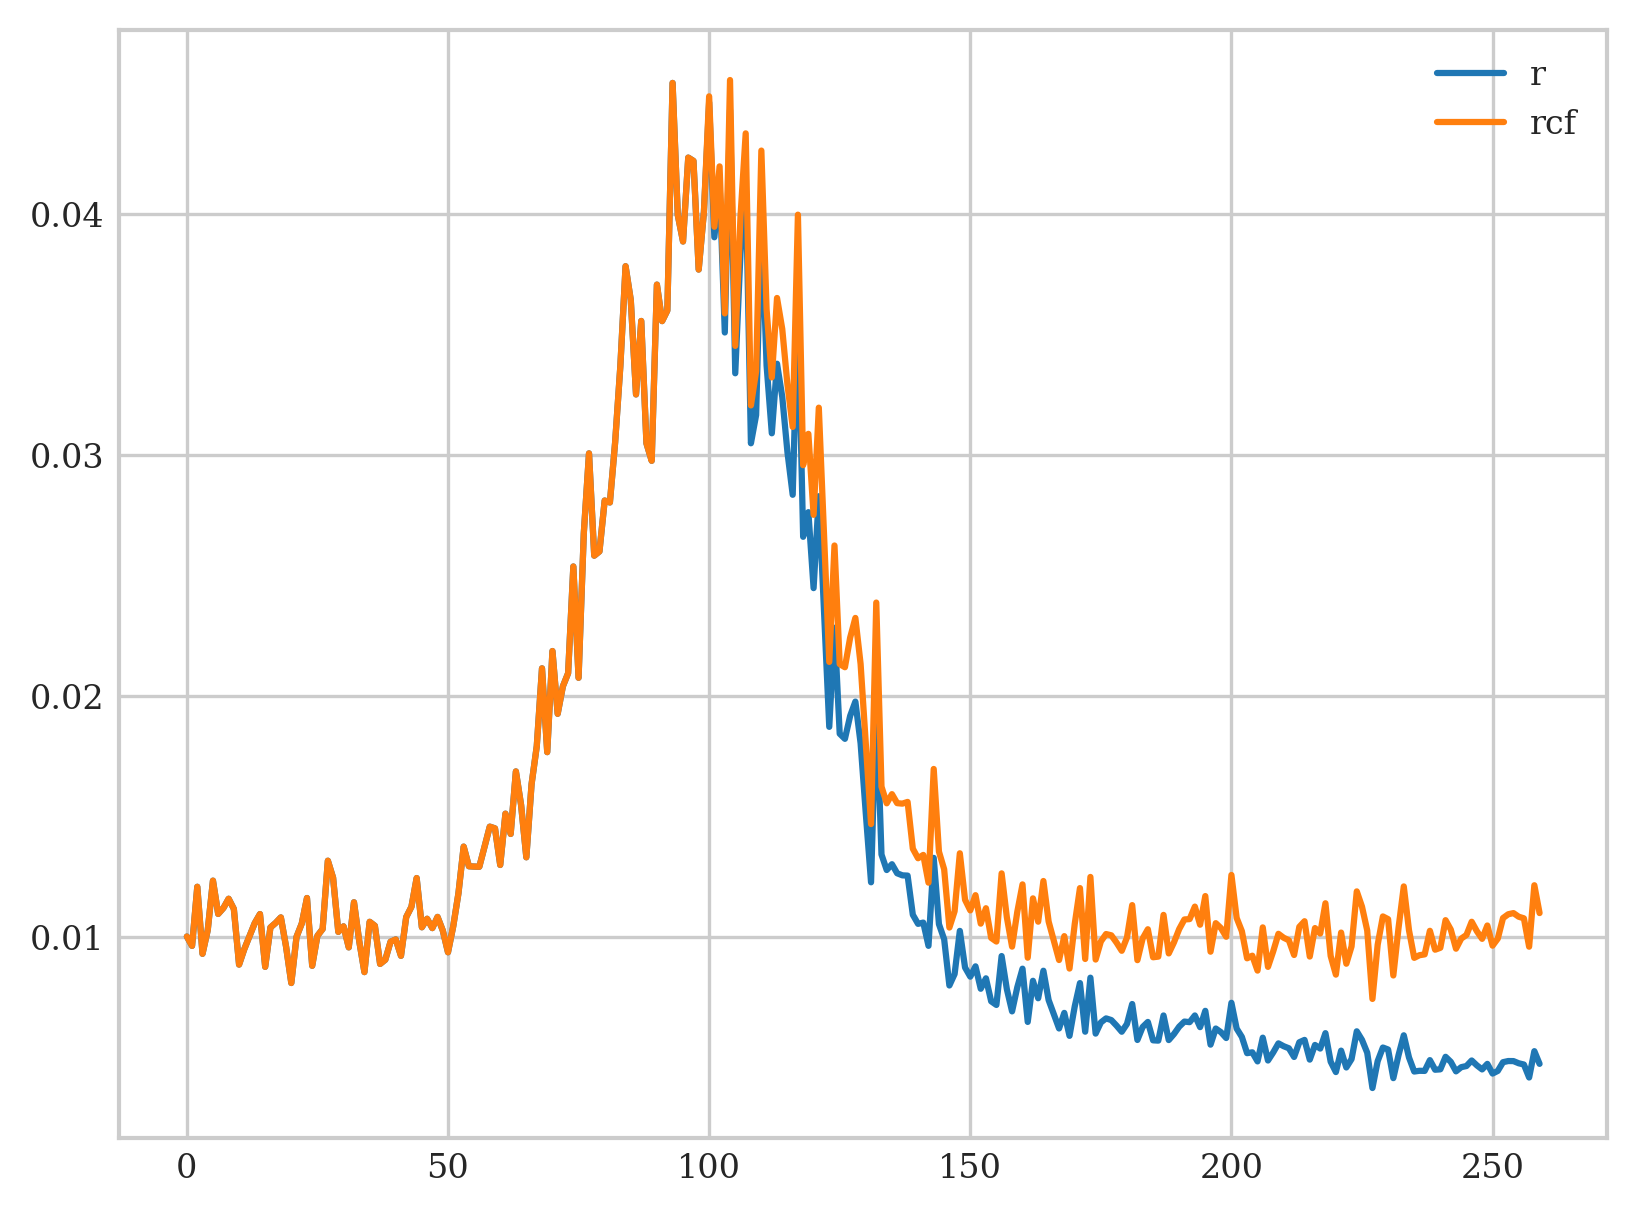

In [4]:
plt.plot(sim_data['true_r_0_t'],label="r")
plt.plot(sim_data['true_rcf_0_t'],label="rcf")
plt.legend()

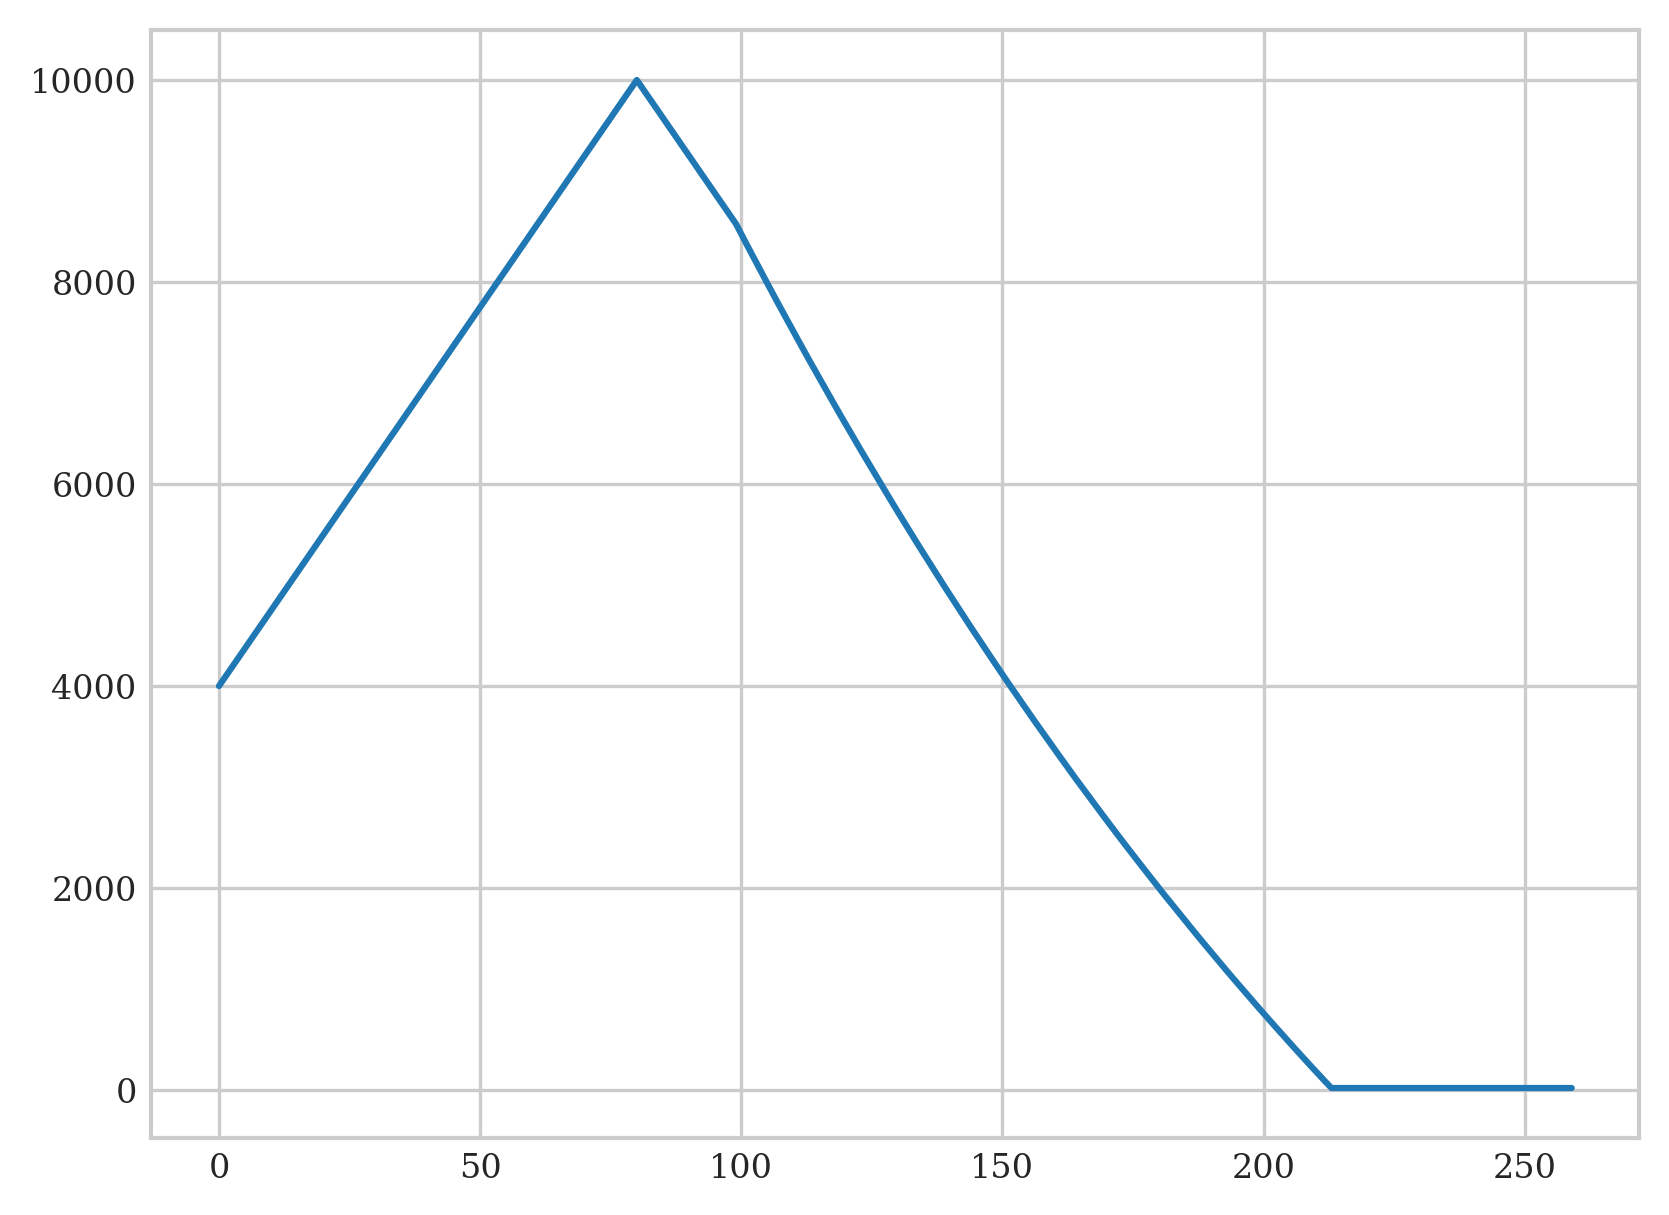

In [5]:
plt.plot(sim_data['c_t'])

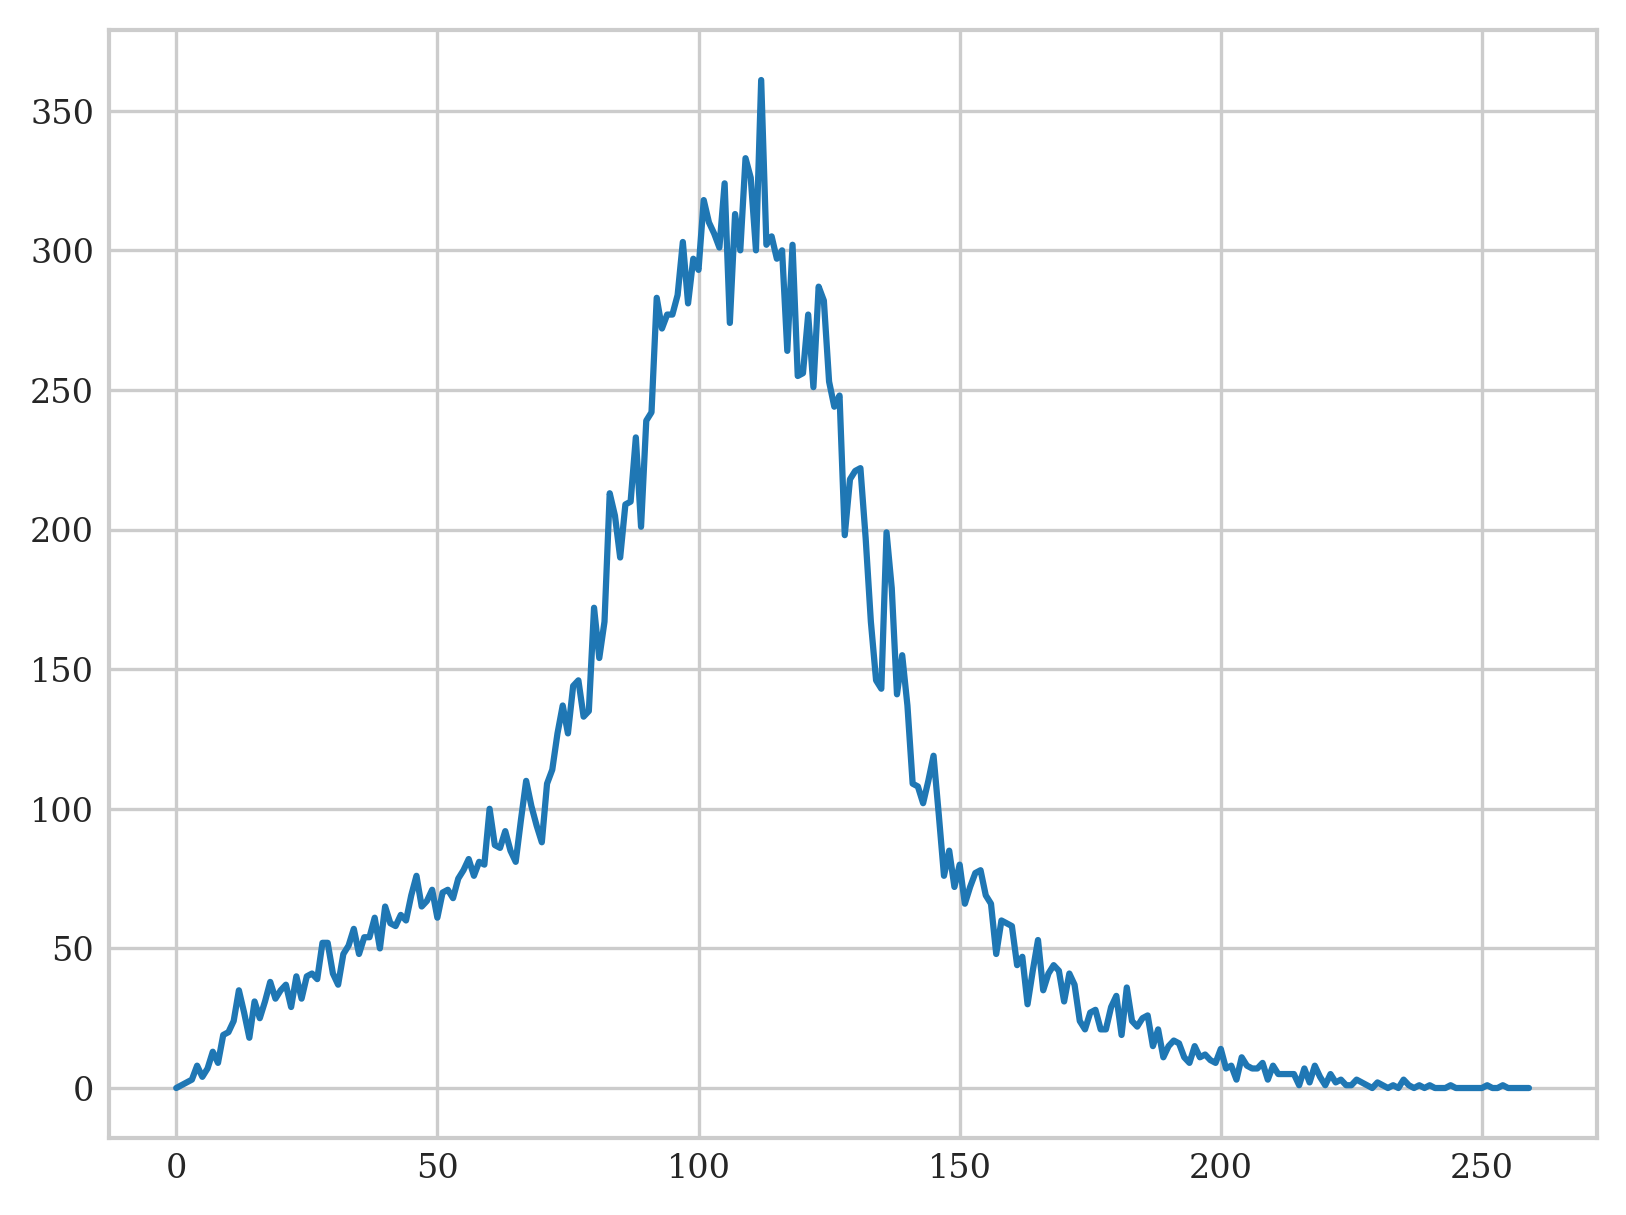

In [6]:
plt.plot(sim_data['d_t'])

## 4. Fit Proposed Bayesian Model (NumPyro)
This step will use the `sampler.py` and `model_fitting.py` modules. 
Ensure your `sampler.py`'s `sample` function has been updated to accept and use the `rng_key` argument.

In [7]:
mcmc_seed = single_run_base_seed + mc_run_index_for_test + 100000 
jax_prng_key_mcmc = jax.random.PRNGKey(mcmc_seed)

print(f"Fitting proposed model (from your sampler.py) for scenario {selected_scenario_config['id']} with MCMC seed {mcmc_seed}...")
start_fit_time = time.time()
posterior_samples, mcmc_obj = model_fitting.fit_proposed_model(sim_data, jax_prng_key_mcmc)
end_fit_time = time.time()
print(f"Model fitting completed in {end_fit_time - start_fit_time:.2f} seconds.")

results_io.save_raw_posterior_samples(selected_scenario_config['id'], mc_run_index_for_test, 
                                     posterior_samples, config.OUTPUT_DIR_POSTERIOR_SAMPLES)
results_io.save_posterior_summary_for_run(selected_scenario_config['id'], mc_run_index_for_test, 
                                          posterior_samples, config.OUTPUT_DIR_POSTERIOR_SUMMARIES)
print(f"Posterior samples and summary saved for this test run.")
if mcmc_obj:
    try: mcmc_obj.print_summary()
    except Exception as e_summary: print(f"Could not print MCMC summary: {e_summary}")

Fitting proposed model (from your sampler.py) for scenario S11 with MCMC seed 304431...
Model fitting completed in 20.84 seconds.
Posterior samples and summary saved for this test run.

                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha[0]     -4.64      0.16     -4.64     -4.88     -4.37    686.95      1.00
      alpha[1]     -4.53      0.20     -4.52     -4.82     -4.22    450.04      1.00
      alpha[2]     -4.97      0.17     -4.96     -5.26     -4.71    508.38      1.00
      alpha[3]     -3.79      0.13     -3.79     -3.99     -3.58    467.10      1.00
      alpha[4]     -2.65      0.13     -2.63     -2.85     -2.42    355.54      1.00
      alpha[5]     -5.22      0.33     -5.30     -5.73     -4.68    187.60      1.00
      alpha[6]     -4.12      0.43     -4.16     -4.85     -3.43    208.24      1.00
      alpha[7]     -6.44      0.95     -6.46     -7.98     -4.88    297.04      1.00
      alpha[8]     -5.25      2.45     -4.92     

## 5. Calculate Benchmark Estimators

In [8]:
print("Calculating benchmark estimates...")
benchmark_r_t_estimates = {
    "cCFR_cumulative": benchmarks.calculate_crude_cfr(
        sim_data["d_t"], sim_data["c_t"], cumulative=True
    ),
    "aCFR_cumulative": benchmarks.calculate_nishiura_cfr_cumulative(
        sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"]
    )
}

print("Calculating credible intervals for benchmarks using Bayesian Beta-Binomial model...")
benchmark_cis = benchmarks.calculate_benchmark_cis_with_bayesian(
    sim_data["d_t"], sim_data["c_t"], sim_data["f_s_true"]
)

print("Benchmark CI calculations complete.")

Calculating benchmark estimates...
Calculating credible intervals for benchmarks using Bayesian Beta-Binomial model...
Benchmark CI calculations complete.


In [9]:
sim_data["Z_input_true"].T.dot(sim_data["Bm_true"])

array([[0.00000000e+00, 0.00000000e+00, 1.56234989e-04, 1.78680182e-01,
        2.27121890e+00, 7.00618664e+00, 1.22857143e+01, 1.23857142e+01,
        9.83868323e+00, 5.76337602e+00]])

## 6. Calculate Evaluation Metrics for this Run (Optional)

In [10]:
print("Calculating evaluation metrics for this single run...")
run_metrics = evaluation.collect_all_metrics(
    sim_data, posterior_samples, benchmark_r_t_estimates, benchmark_cis
)
print("\nMetrics for this run (analysis window):")
run_metrics

Calculating evaluation metrics for this single run...

Metrics for this run (analysis window):


{'scenario_id': 'S11',
 'mae_rt_sCFR': 0.0015311958268284798,
 'mciw_rt_sCFR': 0.015455033630132675,
 'mcic_rt_sCFR': 1.0,
 'mae_rcf_sCFR': 0.0017127229366451502,
 'mciw_rcf_sCFR': 0.019583767279982567,
 'mcic_rcf_sCFR': 1.0,
 'mae_rt_cCFR_cumulative': 0.011723760715124754,
 'mciw_rt_cCFR_cumulative': 0.0005577802322840827,
 'mcic_rt_cCFR_cumulative': 0.005,
 'mae_rt_aCFR_cumulative': 0.009820642189599766,
 'mciw_rt_aCFR_cumulative': 0.0012892211530302065,
 'mcic_rt_aCFR_cumulative': 0.145,
 'bias_beta_abs_1': -3.956779956817627,
 'width_beta_abs_1': 2.5043253898620605,
 'cover_beta_abs_1': False,
 'bias_lambda_1': 1.1219672679901123,
 'width_lambda_1': 4.468367099761963,
 'cover_lambda_1': True}

## 7. Generate Time-Series Plot for this Run

This plot will show true factual and counterfactual $r_t$, 
proposed model's estimates (factual with 95% CrI, and counterfactual mean), 
and benchmark cCFR and aCFR.

Preparing data for time-series plot...


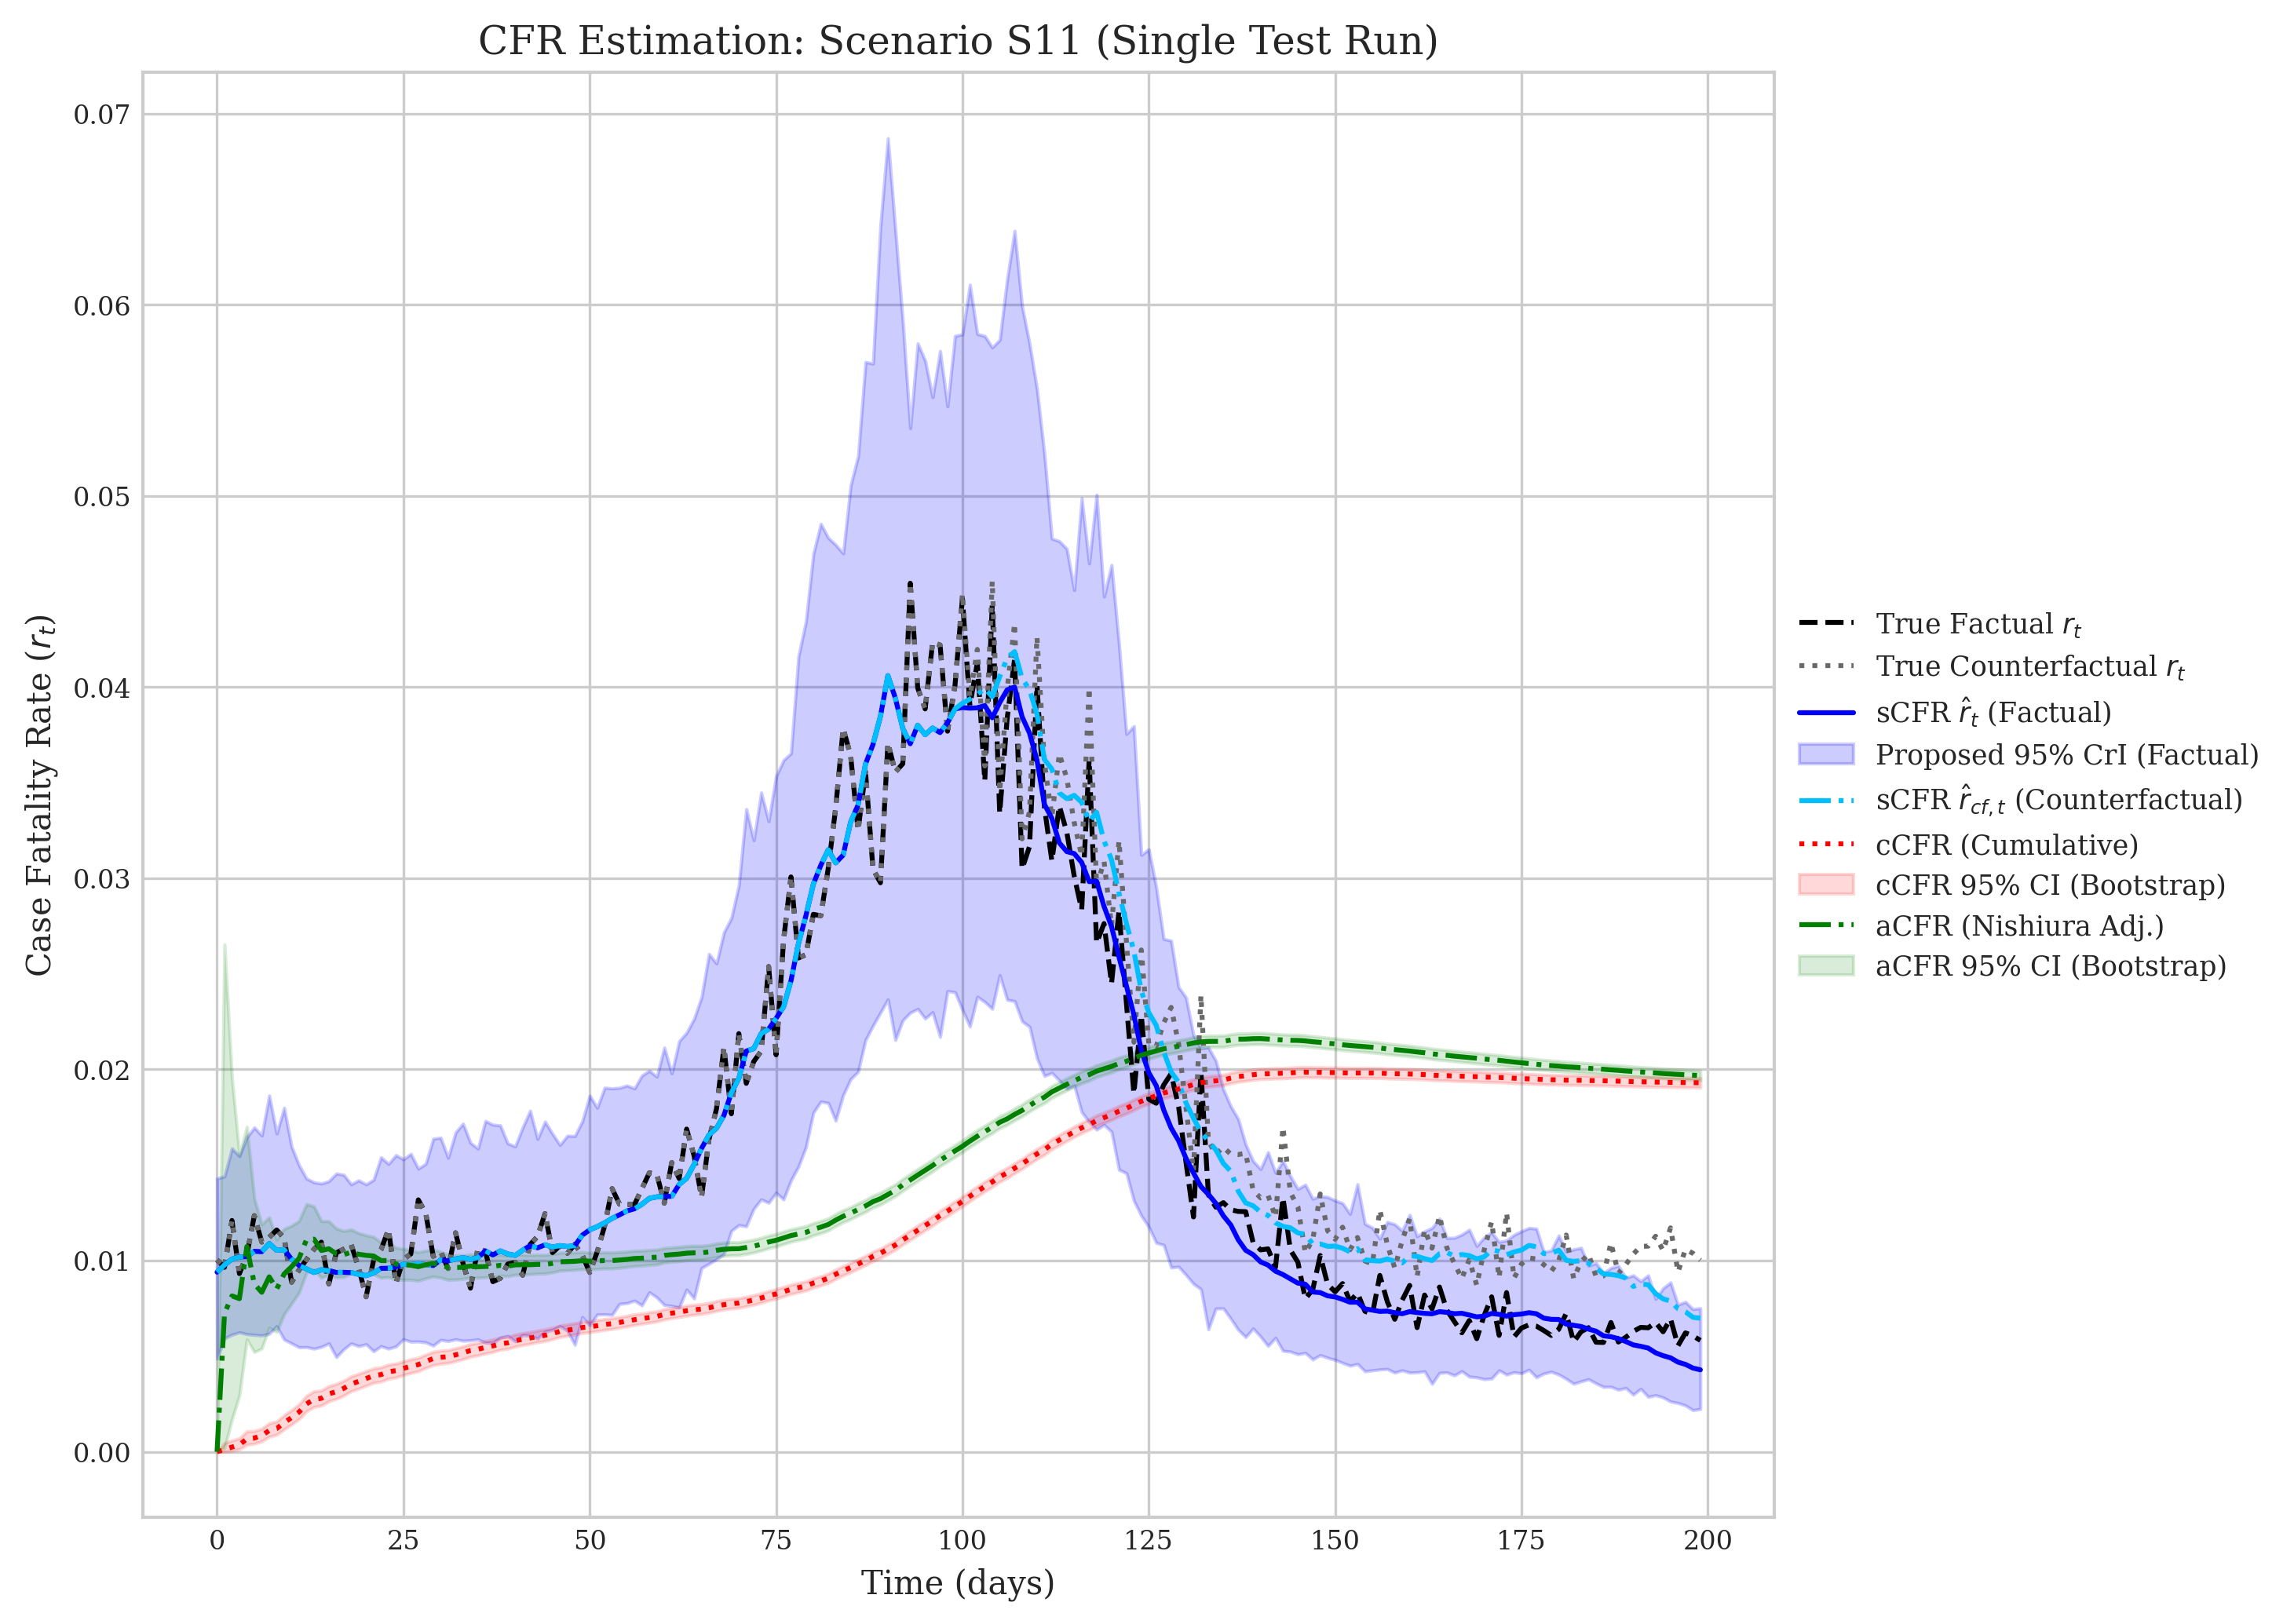

In [11]:
print("Preparing data for time-series plot...")
T_analyze = config.T_ANALYSIS_LENGTH

r_t_mean_sCFR, r_t_lower_sCFR, r_t_upper_sCFR = evaluation.get_posterior_estimates(posterior_samples, "p")
rcf_t_mean_sCFR, _, _ = evaluation.get_posterior_estimates(posterior_samples, "p_cf")

plot_data_for_this_run = {
    "scenario_id": selected_scenario_config['id'], 
    "mc_run_idx": mc_run_index_for_test,
    "true_r_t": sim_data["true_r_0_t"][:T_analyze], 
    "true_rcf_0_t": sim_data["true_rcf_0_t"][:T_analyze],
    "estimated_r_t_dict": {
        "sCFR": {
            "mean": r_t_mean_sCFR[:T_analyze], "lower": r_t_lower_sCFR[:T_analyze], 
            "upper": r_t_upper_sCFR[:T_analyze], "cf_mean": rcf_t_mean_sCFR[:T_analyze]
        },
        "cCFR_cumulative": {
            "mean": benchmark_r_t_estimates["cCFR_cumulative"][:T_analyze],
            "lower": benchmark_cis["cCFR_cumulative_lower"][:T_analyze],
            "upper": benchmark_cis["cCFR_cumulative_upper"][:T_analyze]
        },
        "aCFR_cumulative": {
            "mean": benchmark_r_t_estimates["aCFR_cumulative"][:T_analyze],
            "lower": benchmark_cis["aCFR_cumulative_lower"][:T_analyze],
            "upper": benchmark_cis["aCFR_cumulative_upper"][:T_analyze]
        }
    }
}

# Using the plotting function directly here for inline display
def display_cfr_timeseries_single_run(scenario_id, plot_data_dict, output_dir_plots):
    T_analyze = len(plot_data_dict["true_r_t"])
    time_points = np.arange(T_analyze)

    plt.figure(figsize=(12, 7))
    ax = plt.gca()

    # Plot True curves
    ax.plot(time_points, plot_data_dict["true_r_t"], label="True Factual $r_t$", color='black', linestyle='--')
    ax.plot(time_points, plot_data_dict["true_rcf_0_t"], label="True Counterfactual $r_t$", color='dimgray', linestyle=':')

    # Plot Proposed Model
    prop_est = plot_data_dict["estimated_r_t_dict"]["sCFR"]
    ax.plot(time_points, prop_est["mean"], label="sCFR $\\hat{r}_t$ (Factual)", color='blue')
    ax.fill_between(time_points, prop_est["lower"], prop_est["upper"], color='blue', alpha=0.2, label="Proposed 95% CrI (Factual)")
    ax.plot(time_points, prop_est["cf_mean"], label="sCFR $\\hat{r}_{cf,t}$ (Counterfactual)", color='deepskyblue', linestyle='-.' )

    # Plot Benchmarks with their CIs
    cCFR_est = plot_data_dict["estimated_r_t_dict"]["cCFR_cumulative"]
    ax.plot(time_points, cCFR_est["mean"], label="cCFR (Cumulative)", color='red', linestyle=':')
    ax.fill_between(time_points, cCFR_est["lower"], cCFR_est["upper"], color='red', alpha=0.15, label="cCFR 95% CI (Bootstrap)")

    aCFR_est = plot_data_dict["estimated_r_t_dict"]["aCFR_cumulative"]
    ax.plot(time_points, aCFR_est["mean"], label="aCFR (Nishiura Adj.)", color='green', linestyle='-.' )
    ax.fill_between(time_points, aCFR_est["lower"], aCFR_est["upper"], color='green', alpha=0.15, label="aCFR 95% CI (Bootstrap)")
    
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Case Fatality Rate ($r_t$)")
    ax.set_title(f"CFR Estimation: Scenario {scenario_id} (Single Test Run)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.show()

display_cfr_timeseries_single_run(selected_scenario_config['id'], plot_data_for_this_run, config.OUTPUT_DIR_PLOTS)

## 8. Optional: Further Analysis

You can add more cells here to:
- Plot posterior distributions of $\beta_{abs,k}$ and $\lambda_k$.
- Examine trace plots from the `mcmc_obj` for convergence diagnostics.
- Investigate the estimated random effects `eps` ($\hat{\eta}_t$) from the `posterior_samples`.
For example:

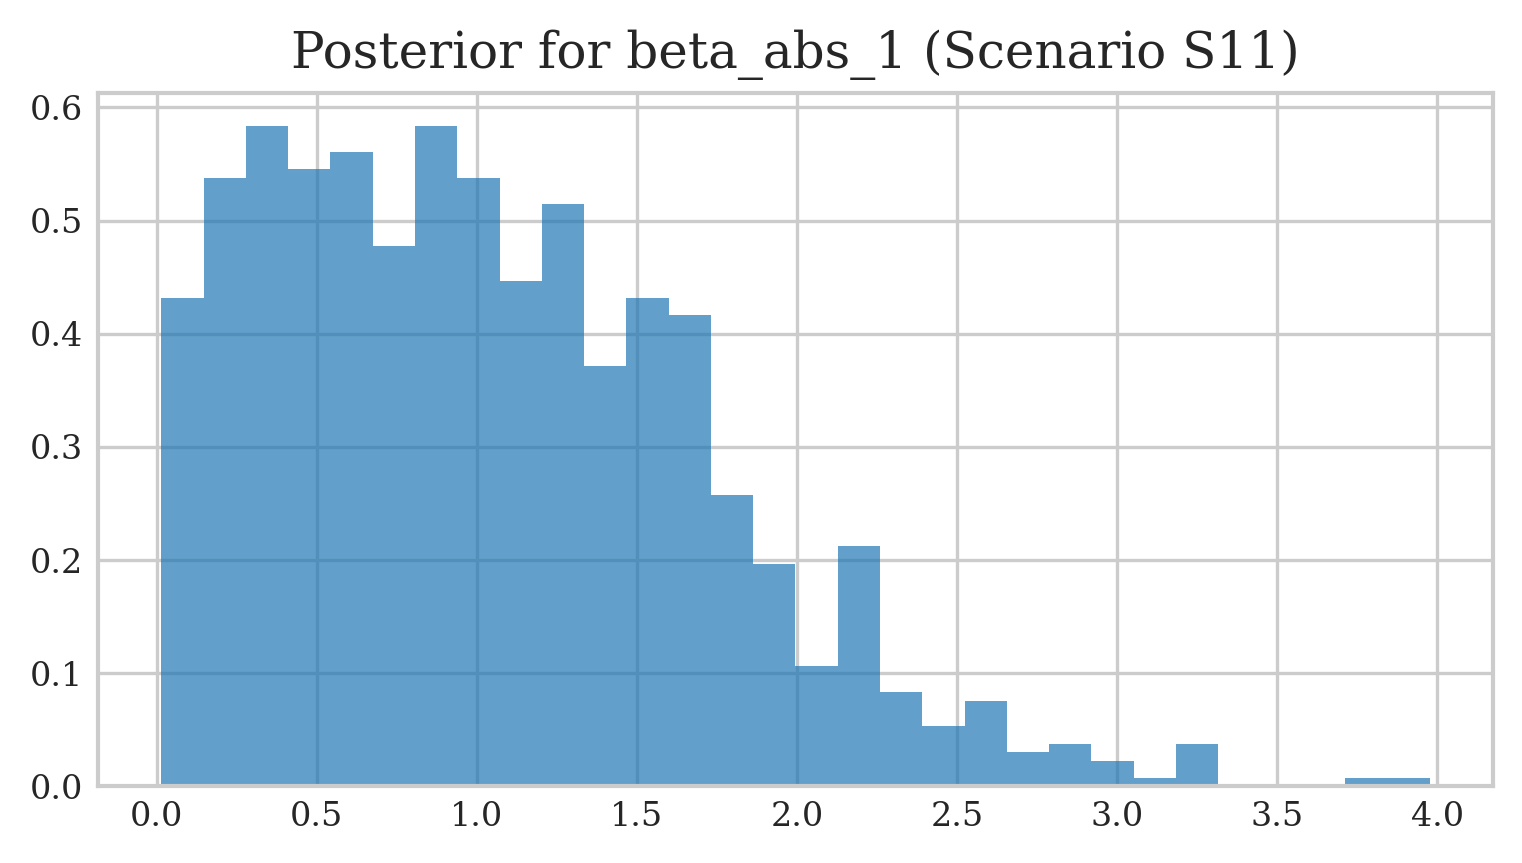

In [12]:
if 'beta_abs' in posterior_samples and posterior_samples['beta_abs'].shape[1] > 0:
    plt.figure(figsize=(6,3))
    plt.hist(posterior_samples['beta_abs'][:,0], bins=30, density=True, alpha=0.7)
    plt.title(f"Posterior for beta_abs_1 (Scenario {selected_scenario_config['id']})")
    plt.show()

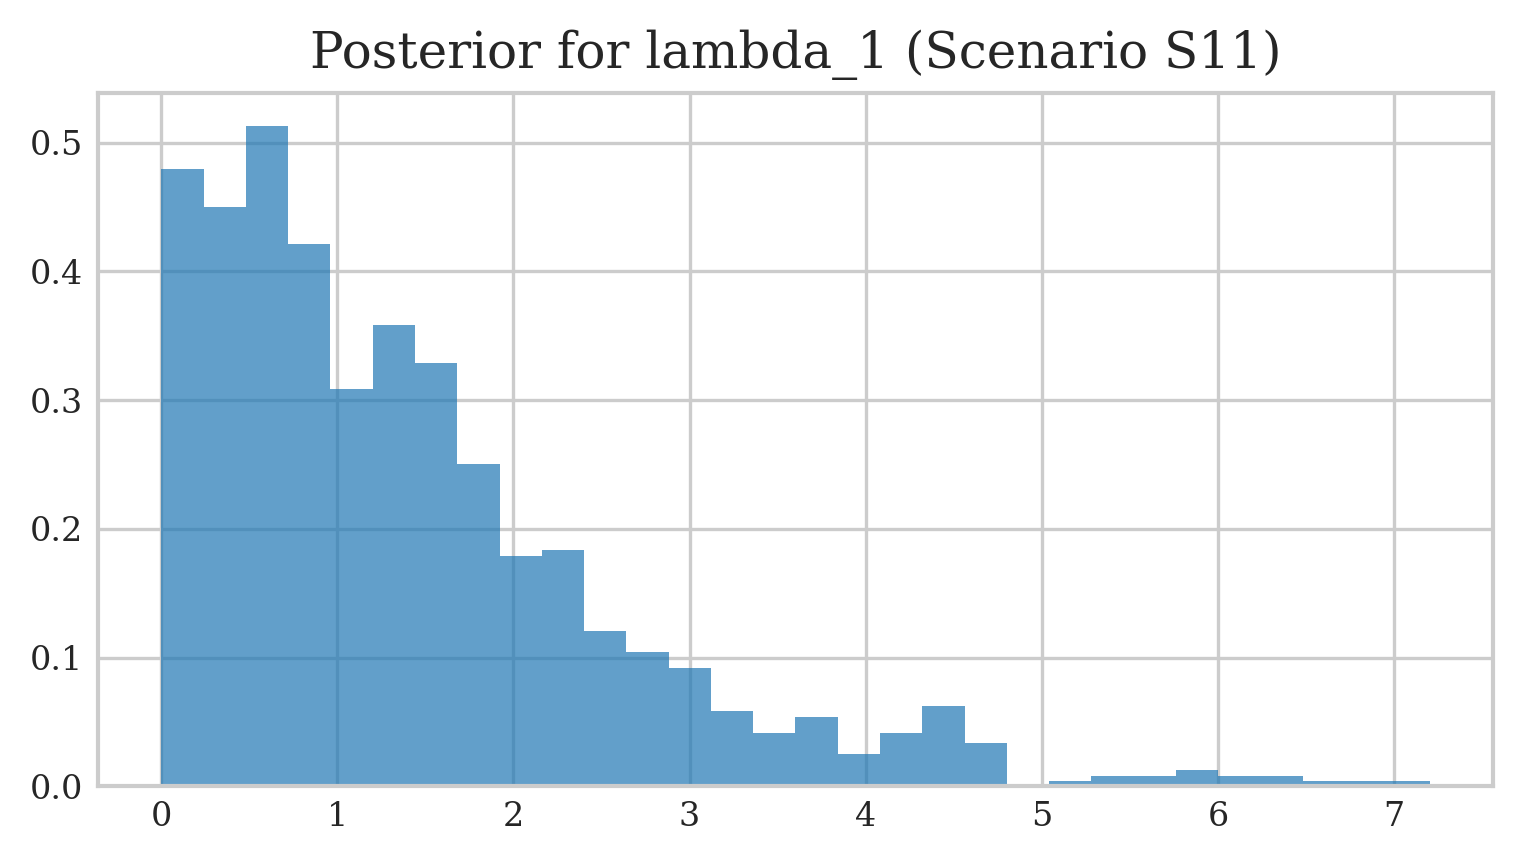

In [13]:
if 'lambda' in posterior_samples and posterior_samples['lambda'].shape[1] > 0:
    plt.figure(figsize=(6,3))
    plt.hist(posterior_samples['lambda'][:,0], bins=30, density=True, alpha=0.7)
    plt.title(f"Posterior for lambda_1 (Scenario {selected_scenario_config['id']})")
    plt.show()